In [47]:
import sys
sys.path.append('/Users/victor/Documents/code/nba_api')

import re
import pandas as pd
import numpy as np
import warnings

from src.espn_scraper import espn_player_scraper
from src.player_stat import get_player_stat, NoDataError

from sqlalchemy import create_engine
from tqdm import tqdm_notebook
from nba_py import player
from time import sleep
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns

## Reading in the data

In [48]:
engine = create_engine("sqlite:///db/nba.db", echo=False)
with engine.connect() as conn:
    stat = pd.read_sql('stat', conn, index_col='nba_id')
    position = pd.read_sql('players', conn, index_col='nba_id')

In [49]:
stat.head()

,shot_res,shot_in_paint,shot_mid_range,shot_lcorner_3,shot_rcorner_3,shot_above_3,fga,block_res,block_in_paint,block_mid_range,block_lcorner_3,block_rcorner_3,block_above_3,blka,oreb,dreb,ast,stl,min
nba_id,,,,,,,,,,,,,,,,,,,
203382,0.515695,0.125561,0.085202,0.022422,0.026906,0.224215,223,0.749999,0.250000,0.000000,0.000000,0.000000,0.000000,12,9.3,18.7,6.3,1.4,2305.288333
1627759,0.367424,0.156566,0.127525,0.032828,0.064394,0.251263,792,0.674418,0.279070,0.000000,0.000000,0.023256,0.023256,43,3.1,12.4,5.0,3.3,4065.096667
1628408,0.333333,0.190476,0.095238,0.000000,0.095238,0.285714,21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,5.7,25.5,4.7,1.9,54.031667
202330,0.261417,0.157480,0.218898,0.050394,0.059843,0.251968,635,0.629629,0.259259,0.037037,0.037037,0.000000,0.037037,27,1.3,16.1,6.3,1.6,1868.588333
201143,0.285319,0.198061,0.235457,0.012465,0.016620,0.252078,722,0.586207,0.379310,0.034483,0.000000,0.000000,0.000000,29,5.1,17.2,14.0,2.3,4249.708333


In [50]:
position.head()

,name,position,espn_player_id,url
nba_id,,,,
203382,aron baynes,C,2968439,http://www.espn.com/nba/player/_/id/2968439/ar...
1627759,jaylen brown,SG,3917376,http://www.espn.com/nba/player/_/id/3917376/ja...
1628408,pj dozier,PG,3923250,http://www.espn.com/nba/player/_/id/3923250/pj...
1626780,jonathan gibson,PG,2234666,http://www.espn.com/nba/player/_/id/2234666/jo...
202330,gordon hayward,SF,4249,http://www.espn.com/nba/player/_/id/4249/gordo...


In [51]:
data = stat.join(position[['position']])

In [52]:
data.head()

,shot_res,shot_in_paint,shot_mid_range,shot_lcorner_3,shot_rcorner_3,shot_above_3,fga,block_res,block_in_paint,block_mid_range,block_lcorner_3,block_rcorner_3,block_above_3,blka,oreb,dreb,ast,stl,min,position
nba_id,,,,,,,,,,,,,,,,,,,,
1713,0.167742,0.066667,0.094624,0.049462,0.066667,0.554839,465,0.555555,0.111111,0.222222,0.0,0.0,0.111111,9,1.9,12.0,6.3,3.6,2356.346667,SF
1717,0.013333,0.072000,0.370667,0.013333,0.042667,0.488000,375,0.000000,0.999995,0.000000,0.0,0.0,0.000000,2,0.9,19.7,5.1,1.6,2695.478333,PF
2037,0.050459,0.162844,0.327982,0.050459,0.034404,0.373853,436,0.125000,0.250000,0.624999,0.0,0.0,0.000000,8,0.9,5.4,14.5,2.5,2864.170000,SG
2199,0.909091,0.070707,0.010101,0.000000,0.000000,0.010101,99,0.499999,0.333333,0.166666,0.0,0.0,0.000000,6,10.2,23.0,3.9,2.4,1660.493333,C
2200,0.382979,0.255319,0.223404,0.021277,0.010638,0.106383,94,0.666666,0.333333,0.000000,0.0,0.0,0.000000,6,2.9,31.1,10.1,0.7,390.961667,C


## EDA

In [53]:
data.shape

(484, 20)

In [54]:
# Getting distribution of class labels
data.position.value_counts()

SG    114
PG    101
PF     96
SF     93
C      71
F       5
G       4
Name: position, dtype: int64

The Forward(F) and Guard(G) should really be explicitly defined. For instance, as either Point Guard (PG) or Shooting Guard (SG). 

Since there are not many observations, I'm just going to make a quick and easy assumption that all Fowards are Small Forwards, and Guards are Point Guards.

Also note we are dealing with slightly imbalanced classes here

In [55]:
# Dealing with label inconsistencies 
data.loc[data.position == "G",'position'] = 'PG'
data.loc[data.position == "F",'position'] = 'SF'

In [56]:
# Calculating class distributions
data.position.value_counts(normalize=True)

SG    0.235537
PG    0.216942
SF    0.202479
PF    0.198347
C     0.146694
Name: position, dtype: float64

### Exploring Structure of the data

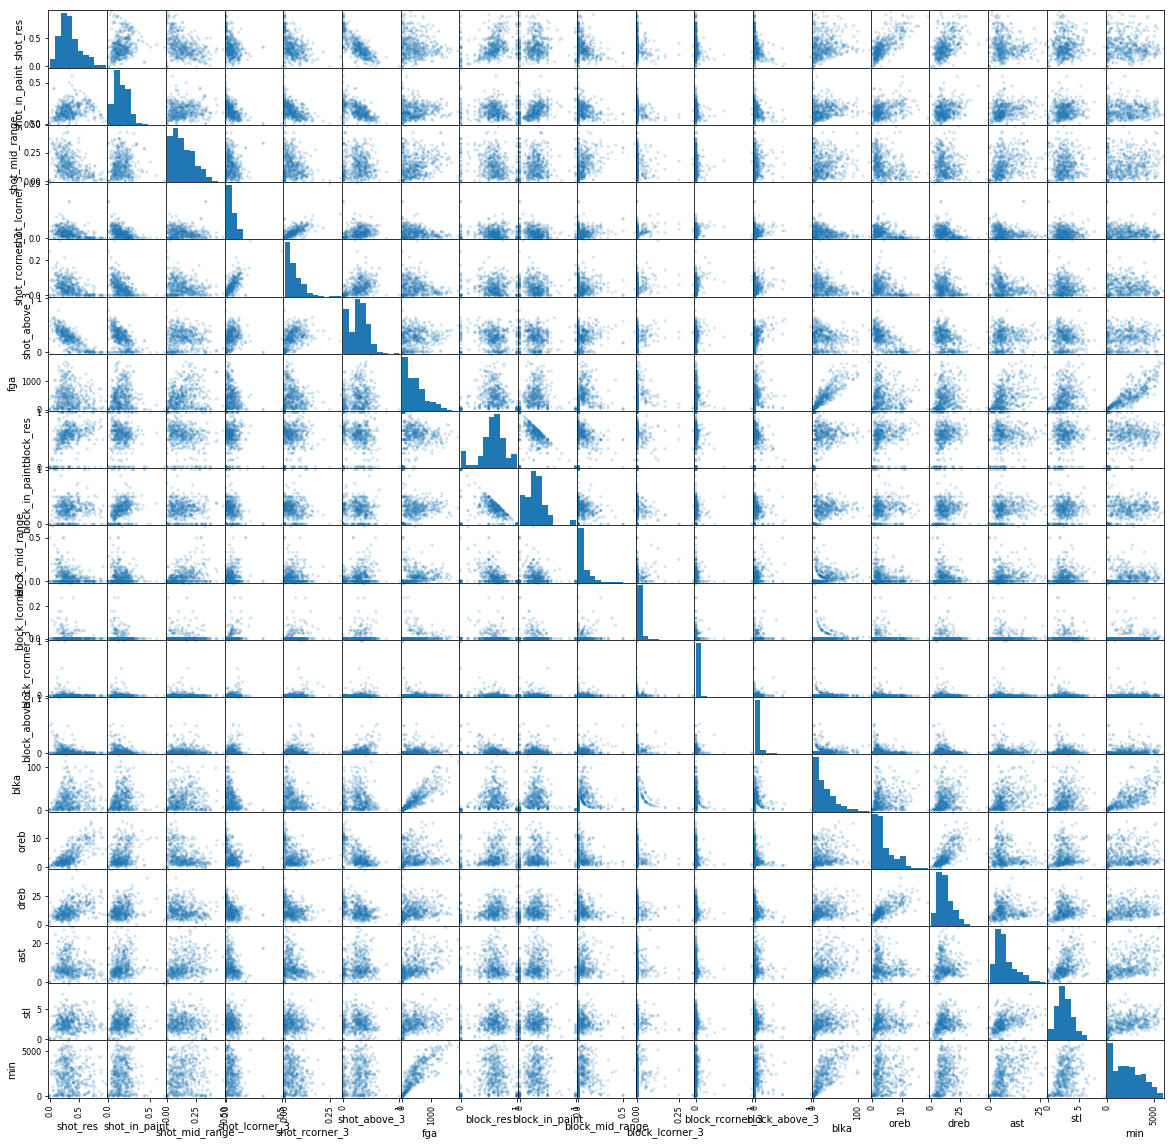

In [57]:
pd.plotting.scatter_matrix(data, alpha = 0.2, figsize=(20,20));

The scatterplot matrix suggests the following, which should be taken into account when modeling
- Many features have outliers
- Many features such as block_mid_range, block_lcorner_3 have a significant number of 0s
- Features mostly follow either skewed normal, or exponential distribution

#### Do we have enough data?
The dataset is made up of 2 types of nba stats, shooting and blocking. That is, the predicative model is based on shooting and blocking stats.

As such, if a player has not attempted many shots or blocks, then predicting his play position will suffer high variance. In other words, dropping players who hasn't had enough should increase prediction accuracy and decrease model variance.

Let's explore a bit deeper on the distribution of shot and block attempts.

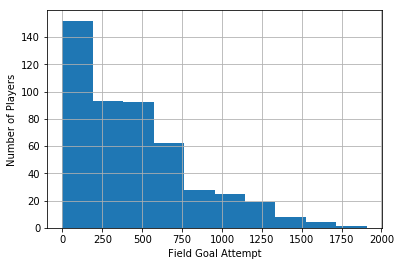

In [58]:
# Shot attempts (field goal attempt)
ax = data.fga.hist()
ax.set_xlabel('Field Goal Attempt')
ax.set_ylabel('Number of Players');

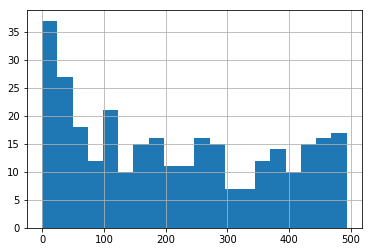

In [59]:
# Explore the lower end
data.loc[data.fga < 500, 'fga'].hist(bins=20)

About 100 players have less than 100 shots. We will consider dropping them as they haven't really played enough for their player position to show through the data

#### Checking Distribution of Block Attempts

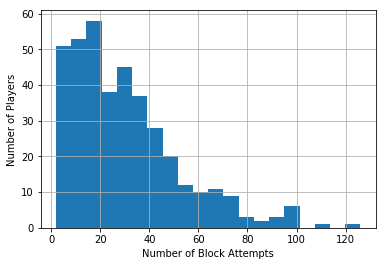

In [64]:
ax = data.blka.hist(bins=20)
ax.set_xlabel('Number of Block Attempts')
ax.set_ylabel('Number of Players');

A significant number of players has less than 20 blocks. We will also keep this in mind when modeling.

### Spliting Data

In [65]:
from sklearn.model_selection import train_test_split
from collections import OrderedDict

# Dropping players with less than 25 shots attempts
data = data[data.fga >= 100]

X = data.drop('position', axis=1)
y = data[['position']]

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Manually encode the labels to make it more meaningful for the confusion matrix later
label_encoder_dict = OrderedDict([
    ("C",0),
    ("PG",1),
    ("SG",2),
    ("SF",3),
    ("PF",4)
])

y_train = y_train.position.map(label_encoder_dict).values
y_test = y_test.position.map(label_encoder_dict).values

print('X_train:',X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (291, 19)
y_train: (291,)
X_test: (97, 19)
y_test: (97,)


In [66]:
X_train.head()

,shot_res,shot_in_paint,shot_mid_range,shot_lcorner_3,shot_rcorner_3,shot_above_3,fga,block_res,block_in_paint,block_mid_range,block_lcorner_3,block_rcorner_3,block_above_3,blka,oreb,dreb,ast,stl,min
nba_id,,,,,,,,,,,,,,,,,,,
201976,0.226891,0.159664,0.023109,0.056723,0.069328,0.464286,476,0.560000,0.400000,0.040000,0.0,0.000000,0.000000,25,4.0,11.2,11.3,4.2,2470.770000
101150,0.259227,0.210896,0.274165,0.019332,0.011424,0.224956,1138,0.575342,0.260274,0.109589,0.0,0.000000,0.054795,73,1.7,7.3,17.4,3.0,4581.678333
1626181,0.405542,0.093199,0.083123,0.085642,0.052897,0.279597,397,0.761904,0.190476,0.047619,0.0,0.000000,0.000000,21,1.3,9.9,7.9,3.4,2188.001667
1627789,0.322581,0.050691,0.096774,0.105991,0.115207,0.308756,217,0.666666,0.277778,0.055556,0.0,0.000000,0.000000,18,1.4,12.5,3.8,2.7,1215.738333
203915,0.328068,0.171324,0.057108,0.029162,0.052248,0.362090,823,0.388889,0.555555,0.000000,0.0,0.027778,0.027778,36,1.5,8.1,18.7,2.4,4220.028333


A big chunk of players do not have meaningful number of blocks. We will keep this feature for now and see if the models think they are important later

## Multinomial Logistic Regression

Why choose it
    - Predicts probability distribution over k classes, which gives us insight on how close the player is to each position/role
    - Performs well when data is not well separated, which is going to be the case for us. The variance in NBA stat is often quite high
    - Can handle weak multicolinearity. We will test with VIF(Variance Inflation Factor) to make sure this is the case, and do dimensionality reduction if there is strong covariance between independent variables (VIF > 10)


In [67]:
# Calculating VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = []
for idx, col in enumerate(X.columns):
    VIF_i = variance_inflation_factor(X.dropna().values, idx)
    vif_data.append([col, VIF_i])

display(pd.DataFrame(vif_data, columns=['Feature', "VIF"]).sort_values("VIF", ascending=False))

,Feature,VIF
7,block_res,1.970510e+12
0,shot_res,7.699119e+11
8,block_in_paint,5.463876e+11
5,shot_above_3,5.140509e+11
1,shot_in_paint,1.617179e+11
2,shot_mid_range,1.441913e+11
9,block_mid_range,4.704014e+10
12,block_above_3,2.936265e+10
4,shot_rcorner_3,2.033008e+10
3,shot_lcorner_3,1.951794e+10


Anything with VIF over 10 exhibits strong multicolinearity with other features, here we are dealing with many feature that has strong correlation with others.

Quickest way to solve this is in this dataset is probably with a combination of standarization, PCA and L1 regularization. 

In [93]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.decomposition import PCA

pipeline = Pipeline([('standarize', StandardScaler()),
                     ('pca', PCA()),
                     ('clf', LogisticRegression(class_weight='balanced', 
                                                max_iter=10000,
                                                multi_class='multinomial',
                                                solver='saga'))])

param_grid = {"clf__penalty":['l1','l2','none'],
              "clf__C":[.5,.75,1,1.25],
              "pca__n_components":[5,10,15,18]
             }

cv = StratifiedKFold(5, shuffle=True)

grid_search = GridSearchCV(pipeline, param_grid, verbose=0, scoring='accuracy', cv=cv, n_jobs=-1)

grid_search.fit(X_train, y_train);

grid_search.score(X_test, y_test)

0.6701030927835051

In [94]:
grid_search.best_estimator_

Pipeline(memory=None,
         steps=[('standarize',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=15,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 LogisticRegression(C=0.5, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='multinomial', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [70]:
warnings.filterwarnings('ignore')

# Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, grid_search.predict(X_test))

Text(60,0.5,'Ground Truth Label')

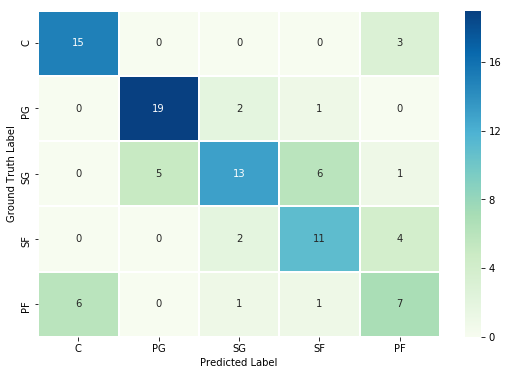

In [71]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
heat_map = sns.heatmap(cm, 
                       annot=True, 
                       fmt="d", 
                       linewidths=1, 
                       ax=ax, 
                       cmap='GnBu',
                       xticklabels=label_encoder_dict.keys(), 
                       yticklabels=label_encoder_dict.keys())

heat_map.set_xlabel("Predicted Label")
heat_map.set_ylabel("Ground Truth Label")

This result is interesting because it shows that based on where a player shoots the ball, and his general stats, we can generally tell which type of player he is. 

Not surprisingly, the difference between a Point Guard and a Shooting Guard is subtle, as misclassification rates are somewhat high between the two groups.

The Power Forward position is also an interesting one, as it often gets misclassified with Center. This makes sense because they have more similar play styles, which is to always play near the restricted zone.

https://sports.stackexchange.com/questions/2172/what-are-the-differences-between-the-power-forward-and-center-positions

## Tree Based Methods

### Random Forest

Why Choose It
    - One of the best out of the box classifiers. It is non-parametric(don't assume underlying data distribution), which makes it robust to many kinds of data and does not require feature preprocessing. 
    - Pretty quick to train compared to XGBoost, which has many more parameters to tune.

In [73]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([('clf', RandomForestClassifier(n_jobs=-1, class_weight='balanced'))])

rf_parameter_grid = {'clf__n_estimators':[100, 500],
                    'clf__max_depth':[8, 12, 16, 18],
                    'clf__min_samples_split':[2, 8, 12, 18]
                    }

rf_gridsearch = GridSearchCV(rf_pipeline, rf_parameter_grid, cv=cv)

In [83]:
rf_gridsearch.fit(X_train, y_train);

In [87]:
rf_gridsearch.score(X_test, y_test)

0.6288659793814433

In [88]:
rf_gridsearch.best_estimator_

Pipeline(memory=None,
         steps=[('clf',
                 RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                        criterion='gini', max_depth=8,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=8,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=500, n_jobs=-1,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

Text(60,0.5,'Ground Truth Label')

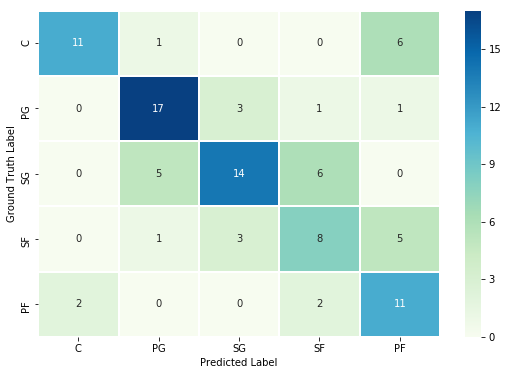

In [99]:
# Draw a heatmap with the numeric values in each cell
cm = confusion_matrix(y_test, rf_gridsearch.predict(X_test))
f, ax = plt.subplots(figsize=(9, 6))
heat_map = sns.heatmap(cm, 
                       annot=True, 
                       fmt="d", 
                       linewidths=1, 
                       ax=ax, 
                       cmap='GnBu',
                       xticklabels=label_encoder_dict.keys(), 
                       yticklabels=label_encoder_dict.keys())

heat_map.set_xlabel("Predicted Label")
heat_map.set_ylabel("Ground Truth Label")

In this case, RF did not perform better than our Multinomial Logistic Regression Classifier. It made similar mistakes compared to the logistic regression model (confusing same types of players), and greater in quantity.

### Boosted Trees

#### XGBoost

In [95]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold

xgb_pipeline = Pipeline([('xgb_clf', XGBClassifier(n_jobs=1, learning_rate=0.1, verbose=10))])

xgb_param_grid1 = {
    'xgb_clf__n_estimators':[75],
    'xgb_clf__gamma':[0, 0.5, 1],
    'xgb_clf__max_depth':[3, 6, 9],
    'xgb_clf__reg_alpha':[0, 0.5, 1], 
    'xgb_clf__reg_lambda':[0, 0.5, 1], 
}

cv = StratifiedKFold(5, shuffle=False)

xgb_grid_cv = GridSearchCV(xgb_pipeline, xgb_param_grid1, cv=cv, verbose=0, n_jobs=-1, refit=True)

In [98]:
xgb_grid_cv.fit(X_train, y_train);

In [97]:
xgb_grid_cv.score(X_test, y_test)

0.5979381443298969

In [80]:
xgb_grid_cv.best_estimator_

Pipeline(memory=None,
         steps=[('xgb_clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bytree=1, gamma=0,
                               learning_rate=0.1, max_delta_step=0, max_depth=9,
                               min_child_weight=1, missing=None,
                               n_estimators=75, n_jobs=1, nthread=None,
                               objective='multi:softprob', random_state=0,
                               reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
                               seed=None, silent=True, subsample=1,
                               verbose=10))],
         verbose=False)